<a href="https://colab.research.google.com/github/Alecia113/NLP-Emotional-analysis/blob/main/winchange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#要用语义，句法词关系来测试。[lab5-word_analogy_evaluation]
#https://colab.research.google.com/drive/1VdNkQpeI6iLPHeTsGe6sdHQFcGyV1Kmi?usp=sharing#scrollTo=EVk7tjwvhl-6

import numpy as np
import re
from lxml import etree 
import pprint
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



id = '1B47OiEiG2Lo1jUY6hy_zMmHBxfKQuJ8-'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ted_en-20160408.xml')  



#data preprocessing
targetXML=open('ted_en-20160408.xml', 'r', encoding='ISO-8859-1')
target_text = etree.parse(targetXML)
parse_text = '\n'.join(target_text.xpath('//content/text()'))
content_text = re.sub(r'\([^)]*\)', '', parse_text)
sent_text=sent_tokenize(content_text)

normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

sentences=[]
sentences=[word_tokenize(sentence) for sentence in normalized_text]

# Prints only 10 (tokenised) sentences
#print(sentences[:10])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# #gensim word2vec #W2V-cbow
# wv_cbow_model = Word2Vec(sentences=sentences, size=100, window=5, min_count=5, workers=2, sg=0)
# wv_cbow_model.wv.save_word2vec_format('ted_cbow_w2v.txt', binary=False)
# vectors_wv_cbow="/content/ted_cbow_w2v.txt"    #打开训练好的文件。vectors_file

# #W2v-skip gram
# wv_sg_model = Word2Vec(sentences=sentences, size=100, window=5, min_count=5, workers=2, sg=1)
# wv_sg_model.wv.save_word2vec_format('ted_sg_w2v.txt', binary=False)
# vectors_wv_sg="/content/ted_sg_w2v.txt"    #打开训练好的文件。vectors_file

# #FastText- sg
# from gensim.models import FastText
# ft_sg_model = FastText(sentences=sentences, size=100, window=5, min_count=5, workers=2, sg=1)
# ft_sg_model.wv.save_word2vec_format('ted_sg_ft.txt', binary=False)
# vectors_ft_sg="/content/ted_sg_ft.txt"    #打开训练好的文件。vectors_file

# # fasttext - cbow
# ft_cbow_model = FastText(sentences=sentences, size=100, window=5, min_count=5, workers=2, sg=0)
# ft_cbow_model.wv.save_word2vec_format('ted_cbow_ft.txt', binary=False)
# vectors_ft_cbow="/content/ted_cbow_ft.txt"    #打开训练好的文件。vectors_file



In [ ]:
#gensim word2vec #W2V-cbow
SIZE= 100
MIN_COUNT = 5
WINDOW = 5
wv_cbow_model = Word2Vec(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=0)
wv_cbow_model.wv.save_word2vec_format('ted_cbow_w2v.txt', binary=False)
vectors_wv_cbow="/content/ted_cbow_w2v.txt"    #打开训练好的文件。vectors_file

#W2v-skip gram
wv_sg_model = Word2Vec(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=1)
wv_sg_model.wv.save_word2vec_format('ted_sg_w2v.txt', binary=False)
vectors_wv_sg="/content/ted_sg_w2v.txt"    #打开训练好的文件。vectors_file

#FastText- sg
from gensim.models import FastText
ft_sg_model = FastText(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=1)
ft_sg_model.wv.save_word2vec_format('ted_sg_ft.txt', binary=False)
vectors_ft_sg="/content/ted_sg_ft.txt"    #打开训练好的文件。vectors_file

# fasttext - cbow
ft_cbow_model = FastText(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=0)
ft_cbow_model.wv.save_word2vec_format('ted_cbow_ft.txt', binary=False)
vectors_ft_cbow="/content/ted_cbow_ft.txt"    #打开训练好的文件。vectors_file



In [ ]:
#匹配
def open_files(file_name):
  with open(file_name, 'r') as f:    #vectors_file == vectors_wv_cbow  ==file_name
    vectors = {}
    for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
      vals = line.rstrip().split(' ')
      vectors[vals[0]] = [x for x in vals[1:]]


  vocab_words=list(vectors.keys())
  vocab_size = len(vocab_words)
  print("Vocab size: ",str(vocab_size))

  # create word->index and index->word converter  
  vocab = {w: idx for idx, w in enumerate(vocab_words)} #每个单词对应个index
  ivocab = {idx: w for idx, w in enumerate(vocab_words)}  #每个index对应一个单词


  # create the embedding matrix of shape (vocab_size, dim)
  vector_dim = len(vectors[ivocab[0]])  #100
  W = np.zeros((vocab_size, vector_dim))    #4325.100
  for word, v in vectors.items():
      if word == '<unk>' or word == '':   #我加的
          continue
      
      W[vocab[word], :] = v   #100 102

  # normalize each word vector to unit length
  # Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
  W_norm = np.zeros(W.shape)
  d = (np.sum(W ** 2, 1) ** (0.5))
  W_norm = (W.T / d).T
  
  return W, vocab, W_norm
#W, vocab

W1,vocab1,W1_norm = open_files(vectors_wv_cbow) #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow
W2,vocab2,W2_norm = open_files(vectors_wv_sg) #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow
W3,vocab3,W3_norm = open_files(vectors_ft_sg) #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow
W4,vocab4,W4_norm = open_files(vectors_ft_cbow) #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow

Vocab size:  21613
Vocab size:  21613
Vocab size:  21613
Vocab size:  21613


In [ ]:

#开始句法文本分析各种的功能语句。
!git clone https://github.com/stanfordnlp/GloVe.git
def evaluate_vectors(W, vocab, prefix='./content/GloVe/eval/question-data/'):#/content/GloVe/eval/question-data
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100

    correct_sem = 0; # count correct semantic questions  计算正确的语义问题
    correct_syn = 0; # count correct syntactic questions 计算正确的句法问题
    correct_tot = 0 # count correct questions   计算正确的问题
    count_sem = 0; # count all semantic questions 计算所有语义问题
    count_syn = 0; # count all syntactic questions  计算所有语法问题
    count_tot = 0 # count all questions   计算所有问题  
    full_count = 0 # count all questions, including those with unknown words    计算所有问题包括不知道n个单词的问题

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]

        if len(data) == 0:
            print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            print("Example missing line:", full_data[0])
            continue

        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])

            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)


            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()

        
        val = (ind4 == predictions) # correct predictions
        count_tot = count_tot + len(ind1) #216
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)

        print("%s:" % filenames[i])
        print('ACCURACY TOP1: %.2f%% (%d/%d)' %
            (np.mean(val) * 100, np.sum(val), len(val)))
        
    return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count
'''
#可视化展示
correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')#/content/GloVe/eval/question-data
print('Questions seen/total: %.2f%% (%d/%d)' %    #看到的问题
    (100 * count_tot / float(full_count), count_tot, full_count))
print('Semantic accuracy: %.2f%%  (%i/%i)' %  #语义准确度 绿色的
    (100 * correct_sem / float(count_sem), correct_sem, count_sem))
print('Syntactic accuracy: %.2f%%  (%i/%i)' % #语法准确度 蓝色的
    (100 * correct_syn / float(count_syn), correct_syn, count_syn))
print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))
  #总准确度红线
'''

Cloning into 'GloVe'...
remote: Enumerating objects: 595, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 595 (delta 0), reused 1 (delta 0), pack-reused 592
Receiving objects: 100% (595/595), 222.33 KiB | 2.32 MiB/s, done.
Resolving deltas: 100% (338/338), done.


"\n#可视化展示\ncorrect_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')#/content/GloVe/eval/question-data\nprint('Questions seen/total: %.2f%% (%d/%d)' %    #看到的问题\n    (100 * count_tot / float(full_count), count_tot, full_count))\nprint('Semantic accuracy: %.2f%%  (%i/%i)' %  #语义准确度 绿色的\n    (100 * correct_sem / float(count_sem), correct_sem, count_sem))\nprint('Syntactic accuracy: %.2f%%  (%i/%i)' % #语法准确度 蓝色的\n    (100 * correct_syn / float(count_syn), correct_syn, count_syn))\nprint('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))\n  #总准确度红线\n"

In [ ]:
# 1-vectors_wv_cbow； 2-vectors_wv_sg； 3-vectors_ft_sg； 4vectors_ft_cbow
def show_answer(W_norm,vocab):
  #可视化展示
  correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')#/content/GloVe/eval/question-data
  Semantic = 100 * correct_sem / float(count_sem)
  Syntactic = 100 * correct_syn / float(count_syn)
  Total = 100 * correct_tot / float(count_tot)
  return Semantic, Syntactic, Total
  #overall
Semantic_wv_cbow, Syntactic_wv_cbow, Total_wv_cbow = show_answer(W1_norm, vocab1)
print(Total_wv_cbow)
print('\n')
Semantic_wv_sg, Syntactic_wv_sg, Total_wv_sg = show_answer(W2_norm, vocab2)
print(Total_wv_sg)
print('\n')
Semantic_ft_sg, Syntactic_ft_sg, Total_ft_sg = show_answer(W3_norm, vocab3)
print(Total_ft_sg)
print('\n')
Semantic_ft_cbow, Syntactic_ft_cbow, Total_ft_cbow = show_answer(W4_norm, vocab4)
print(Total_ft_cbow)

capital-common-countries.txt:
ACCURACY TOP1: 6.99% (19/272)
capital-world.txt:
ACCURACY TOP1: 3.16% (16/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 1.83% (10/545)
family.txt:
ACCURACY TOP1: 40.94% (140/342)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 1.23% (10/812)
gram2-opposite.txt:
ACCURACY TOP1: 0.79% (4/506)
gram3-comparative.txt:
ACCURACY TOP1: 30.41% (405/1332)
gram4-superlative.txt:
ACCURACY TOP1: 11.51% (87/756)
gram5-present-participle.txt:
ACCURACY TOP1: 33.77% (335/992)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 2.00% (17/849)
gram7-past-tense.txt:
ACCURACY TOP1: 23.68% (351/1482)
gram8-plural.txt:
ACCURACY TOP1: 15.05% (140/930)
gram9-plural-verbs.txt:
ACCURACY TOP1: 16.67% (126/756)
16.42101098031457


capital-common-countries.txt:
ACCURACY TOP1: 4.78% (13/272)
capital-world.txt:
ACCURACY TOP1: 4.34% (22/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 2.20% (12/545)
family.txt:
ACCURACY TOP1: 41.

In [ ]:
SIZE= 100
MIN_COUNT = 5
WINDOW = 5

In [ ]:
#table
from prettytable import PrettyTable
x = PrettyTable(['Model','Size','Window','Min_count','|','Sem','Syn','Tot'])
x.align['Model'] = '1' #以model字段左对齐
x.padding_width = 1 #填充快读
x.add_row(['W2V_cbow','100','5','5','|',Semantic_wv_cbow, Syntactic_wv_cbow, Total_wv_cbow])
x.add_row(['W2V_sg  ','100','5','5','|',Semantic_wv_sg, Syntactic_wv_sg, Total_wv_sg])
x.add_row(['Ft_sg   ','100','5','5','|',Semantic_ft_sg, Syntactic_ft_sg, Total_ft_sg])
x.add_row(['Ft_cbow ','100','5','5','|',Semantic_ft_cbow, Syntactic_ft_cbow, Total_ft_cbow])
print(x)

+----------+------+--------+-----------+---+--------------------+--------------------+--------------------+
|  Model   | Size | Window | Min_count | | |        Sem         |        Syn         |        Tot         |
+----------+------+--------+-----------+---+--------------------+--------------------+--------------------+
| W2V_cbow | 100  |   5    |     5     | | | 10.920897284533648 | 17.528223410576352 | 16.42101098031457  |
| W2V_sg   | 100  |   5    |     5     | | | 11.15702479338843  | 20.558526440879383 | 18.983084380255217 |
| Ft_sg    | 100  |   5    |     5     | | |  9.50413223140496  |  66.3220439691028  | 56.800870511425465 |
| Ft_cbow  | 100  |   5    |     5     | | | 5.017709563164108  | 56.613190730837786 | 47.967157978039374 |
+----------+------+--------+-----------+---+--------------------+--------------------+--------------------+


In [ ]:
#Ft_sg 2h
def size_change(name, sgn):
  size = [100,200,300,400,500,600] #x
  MIN_COUNT = 5
  WINDOW = 10
  Sem_test = []
  Syn_test = []
  Tot_test = []
  for s_size in range(len(size)):
    SIZE = size[s_size]
    size_change = name(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg = sgn) #FastText
    size_change.wv.save_word2vec_format('size_change.txt', binary=False)
    vectors="/content/size_change.txt"    #打开训练好的文件。vectors_file

    W_test,vocab_test,W_test_norm = open_files(vectors)
    Semantic_test, Syntactic_test, Total_test = show_answer(W_test_norm, vocab_test)
    Sem_test.append(Semantic_test)
    Syn_test.append(Syntactic_test)
    Tot_test.append(Total_test)
  return Sem_test, Syn_test, Tot_test


#Sem_ftsg, Syn_ftsg, Tot_ftsy = size_change(FastText,1)


# print(Sem_ftsg)
# print(Syn_ftsg)
# print(Tot_ftsg) 
#y=accuary
#1多h

In [ ]:
Sem_ftsg, Syn_ftsg, Tot_ftsy = size_change(FastText,1)


Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 1.10% (3/272)
capital-world.txt:
ACCURACY TOP1: 2.56% (13/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 1.47% (8/545)
family.txt:
ACCURACY TOP1: 31.87% (109/342)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 70.32% (571/812)
gram2-opposite.txt:
ACCURACY TOP1: 76.48% (387/506)
gram3-comparative.txt:
ACCURACY TOP1: 78.00% (1039/1332)
gram4-superlative.txt:
ACCURACY TOP1: 85.85% (649/756)
gram5-present-participle.txt:
ACCURACY TOP1: 78.43% (778/992)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 47.23% (401/849)
gram7-past-tense.txt:
ACCURACY TOP1: 35.36% (524/1482)
gram8-plural.txt:
ACCURACY TOP1: 70.43% (655/930)
gram9-plural-verbs.txt:
ACCURACY TOP1: 71.16% (538/756)
Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 1.84% (5/272)
capital-world.txt:
ACCURACY TOP1: 2.56% (13/507)
currency.txt:
ACCURACY TOP1: 3.57% (1/28)
city-in-state.txt:
ACCURACY TOP1: 3.12% (17/545)
family

In [ ]:
Sem_ftcb, Syn_ftcb, Tot_ftcb = size_change(FastText,0)
Sem_wvcb, Syn_wvcb, Tot_wvcb = size_change(FastText,0)
Sem_wvsg, Syn_wvsg, Tot_wvsy = size_change(FastText,1)


In [ ]:
# #gensim word2vec #W2V-cbow
# SIZE= 100
# MIN_COUNT = 5
# WINDOW = 5
# wv_cbow_model = Word2Vec(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=0)
# wv_cbow_model.wv.save_word2vec_format('ted_cbow_w2v.txt', binary=False)
# vectors_wv_cbow="/content/ted_cbow_w2v.txt"    #打开训练好的文件。vectors_file

# #W2v-skip gram
# wv_sg_model = Word2Vec(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=1)
# wv_sg_model.wv.save_word2vec_format('ted_sg_w2v.txt', binary=False)
# vectors_wv_sg="/content/ted_sg_w2v.txt"    #打开训练好的文件。vectors_file

# #FastText- sg
# from gensim.models import FastText
# ft_sg_model = FastText(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=1)
# ft_sg_model.wv.save_word2vec_format('ted_sg_ft.txt', binary=False)
# vectors_ft_sg="/content/ted_sg_ft.txt"    #打开训练好的文件。vectors_file

# # fasttext - cbow
# ft_cbow_model = FastText(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=0)
# ft_cbow_model.wv.save_word2vec_format('ted_cbow_ft.txt', binary=False)
# vectors_ft_cbow="/content/ted_cbow_ft.txt"    #打开训练好的文件。vectors_file



In [ ]:
#Ft_sg 2h
'''
第一个图：window = 10； size【0-600】（x） 把后三个准确率是y  【0，100,200,300,400,500,600]
第二个图：size = 100 ； window【2-10】 [2.4.6,8,10]
第三个图没get到。
'''
'''
size = [100,200,300,400,500,600] #x
MIN_COUNT = 5
WINDOW = 10
Sem_ftsg = []
Syn_ftsg = []
Tot_ftsg = []
for s_size in range(len(size)):
  SIZE = size[s_size]
  test_ftsg = FastText(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=1)
  test_ftsg.wv.save_word2vec_format('test_ftsg.txt', binary=False)
  vectors_ftsg="/content/test_ftsg.txt"    #打开训练好的文件。vectors_file

  W_test,vocab_test,W_test_norm = open_files(vectors_ftsg)
  Semantic_ftsg, Syntactic_ftsg, Total_ftsg = show_answer(W_test_norm, vocab_test)
  Sem_ftsg.append(Semantic_ftsg)
  Syn_ftsg.append(Syntactic_ftsg)
  Tot_ftsg.append(Total_ftsg)
print(Sem_ftsg)
print(Syn_ftsg)
print(Tot_ftsg)
#y=accuary
#1多h
'''

Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 0.74% (2/272)
capital-world.txt:
ACCURACY TOP1: 1.58% (8/507)
currency.txt:
ACCURACY TOP1: 3.57% (1/28)
city-in-state.txt:
ACCURACY TOP1: 2.57% (14/545)
family.txt:
ACCURACY TOP1: 26.90% (92/342)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 80.05% (650/812)
gram2-opposite.txt:
ACCURACY TOP1: 88.54% (448/506)
gram3-comparative.txt:
ACCURACY TOP1: 80.86% (1077/1332)
gram4-superlative.txt:
ACCURACY TOP1: 93.25% (705/756)
gram5-present-participle.txt:
ACCURACY TOP1: 79.44% (788/992)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 57.24% (486/849)
gram7-past-tense.txt:
ACCURACY TOP1: 35.76% (530/1482)
gram8-plural.txt:
ACCURACY TOP1: 73.76% (686/930)
gram9-plural-verbs.txt:
ACCURACY TOP1: 80.56% (609/756)
Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 0.74% (2/272)
capital-world.txt:
ACCURACY TOP1: 1.58% (8/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 2.20% (12/545)
family.t

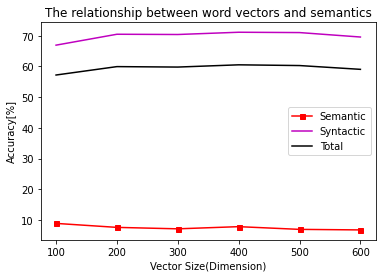

8089.492671243


In [ ]:
import matplotlib.pyplot as plt
import time
#等差数列。
x = [100,200,300,400,500,600]  #100-600
y1 = [Semantic for Semantic in Sem_ftsg]
y2 = [Syntactic for Syntactic in Syn_ftsg]
y3 = [Total for Total in Tot_ftsg]
plt.plot(x,y1,'rs-',markersize =5,label = 'Semantic')
plt.plot(x,y2,'m-',markersize =5,label = 'Syntactic')
plt.plot(x,y3,'k-',markersize =5,label = 'Total')
plt.xlabel('Vector Size(Dimension)')
plt.ylabel('Accuracy[%]')
plt.title('The relationship between word vectors and semantics')
plt.legend()
plt.show()

print(time.process_time()) # 返回进程运行时间

Window size变  size 不变

In [ ]:
WINDOW = [2,4,6,8,10]
for win in range(len(WINDOW)):
  WINDOW1 = WINDOW[win]
  print(WINDOW1)

2
4
6
8
10


In [ ]:
#Ft_sg
'''
第一个图：window = 10； size【0-600】（x） 把后三个准确率是y  【0，100,200,300,400,500,600]
第二个图：size = 100 ； window【2-10】 [2.4.6,8,10]
第三个图没get到。
'''
import time
since = time.time()
def win_change(name,sgn):
  SIZE = 100 #x
  MIN_COUNT = 5
  WINDOW = [2,4,6,8,10]
  Sem_win = []
  Syn_win = []
  Tot_win = []
  for win in range(len(WINDOW)):
    WINDOW1 = WINDOW[win]
    test_win = name(sentences=sentences, size=SIZE, window=WINDOW1, min_count=MIN_COUNT, workers=2, sg=sgn)
    test_win.wv.save_word2vec_format('test_win.txt', binary=False)
    vectors_win="/content/test_win.txt"    #打开训练好的文件。vectors_file

    W_test,vocab_test,W_test_norm = open_files(vectors_win)
    Semantic_win, Syntactic_win, Total_win= show_answer(W_test_norm, vocab_test)
    Sem_win.append(Semantic_win)
    Syn_win.append(Syntactic_win)
    Tot_win.append(Total_win)
  
  return Sem_win, Syn_win, Tot_win

  
# print(Sem_win_ftsg)
# print(Syn_win_ftsg)
# print(Tot_win_ftsg)
time_elapsed = time.time() - since
print('The code run {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#y=accuary


The code run 0m 0s


In [ ]:
#运行。
Sem_win_ftsg, Syn_win_ftsg, Tot_win_ftsy = win_change(FastText,1)


Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 0.74% (2/272)
capital-world.txt:
ACCURACY TOP1: 2.56% (13/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 2.02% (11/545)
family.txt:
ACCURACY TOP1: 30.70% (105/342)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 82.88% (673/812)
gram2-opposite.txt:
ACCURACY TOP1: 85.18% (431/506)
gram3-comparative.txt:
ACCURACY TOP1: 78.75% (1049/1332)
gram4-superlative.txt:
ACCURACY TOP1: 90.48% (684/756)
gram5-present-participle.txt:
ACCURACY TOP1: 82.06% (814/992)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 31.57% (268/849)
gram7-past-tense.txt:
ACCURACY TOP1: 33.06% (490/1482)
gram8-plural.txt:
ACCURACY TOP1: 62.15% (578/930)
gram9-plural-verbs.txt:
ACCURACY TOP1: 77.38% (585/756)
Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 0.74% (2/272)
capital-world.txt:
ACCURACY TOP1: 1.97% (10/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 3.30% (18/545)
famil

In [ ]:
Sem_win_ftcb, Syn_win_ftcb, Tot_win_ftcb = win_change(FastText,0)


Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 1.10% (3/272)
capital-world.txt:
ACCURACY TOP1: 0.99% (5/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 0.18% (1/545)
family.txt:
ACCURACY TOP1: 24.27% (83/342)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 71.92% (584/812)
gram2-opposite.txt:
ACCURACY TOP1: 85.77% (434/506)
gram3-comparative.txt:
ACCURACY TOP1: 81.01% (1079/1332)
gram4-superlative.txt:
ACCURACY TOP1: 88.76% (671/756)
gram5-present-participle.txt:
ACCURACY TOP1: 63.91% (634/992)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 18.96% (161/849)
gram7-past-tense.txt:
ACCURACY TOP1: 19.77% (293/1482)
gram8-plural.txt:
ACCURACY TOP1: 51.51% (479/930)
gram9-plural-verbs.txt:
ACCURACY TOP1: 71.03% (537/756)
Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 1.10% (3/272)
capital-world.txt:
ACCURACY TOP1: 0.79% (4/507)
currency.txt:
ACCURACY TOP1: 3.57% (1/28)
city-in-state.txt:
ACCURACY TOP1: 0.18% (1/545)
family.txt

In [ ]:
Sem_win_wvcb, Syn_win_wvcb, Tot_win_wvcb = win_change(FastText,0)


Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 0.37% (1/272)
capital-world.txt:
ACCURACY TOP1: 0.99% (5/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 0.55% (3/545)
family.txt:
ACCURACY TOP1: 23.68% (81/342)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 71.55% (581/812)
gram2-opposite.txt:
ACCURACY TOP1: 86.36% (437/506)
gram3-comparative.txt:
ACCURACY TOP1: 81.23% (1082/1332)
gram4-superlative.txt:
ACCURACY TOP1: 88.23% (667/756)
gram5-present-participle.txt:
ACCURACY TOP1: 63.51% (630/992)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 18.85% (160/849)
gram7-past-tense.txt:
ACCURACY TOP1: 19.23% (285/1482)
gram8-plural.txt:
ACCURACY TOP1: 52.15% (485/930)
gram9-plural-verbs.txt:
ACCURACY TOP1: 70.37% (532/756)
Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 0.74% (2/272)
capital-world.txt:
ACCURACY TOP1: 0.99% (5/507)
currency.txt:
ACCURACY TOP1: 3.57% (1/28)
city-in-state.txt:
ACCURACY TOP1: 0.55% (3/545)
family.txt

In [ ]:
Sem_win_wvsg, Syn_win_wvsg, Tot_win_wvsy = win_change(FastText,1)


Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 0.37% (1/272)
capital-world.txt:
ACCURACY TOP1: 2.56% (13/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 1.83% (10/545)
family.txt:
ACCURACY TOP1: 28.36% (97/342)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 82.64% (671/812)
gram2-opposite.txt:
ACCURACY TOP1: 87.94% (445/506)
gram3-comparative.txt:
ACCURACY TOP1: 78.23% (1042/1332)
gram4-superlative.txt:
ACCURACY TOP1: 89.81% (679/756)
gram5-present-participle.txt:
ACCURACY TOP1: 81.25% (806/992)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 34.28% (291/849)
gram7-past-tense.txt:
ACCURACY TOP1: 33.87% (502/1482)
gram8-plural.txt:
ACCURACY TOP1: 61.40% (571/930)
gram9-plural-verbs.txt:
ACCURACY TOP1: 78.17% (591/756)
Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 0.74% (2/272)
capital-world.txt:
ACCURACY TOP1: 1.58% (8/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 2.02% (11/545)
family.

In [ ]:
#Ft_sg
'''
第一个图：window = 10； size【0-600】（x） 把后三个准确率是y  【0，100,200,300,400,500,600]
第二个图：size = 100 ； window【2-10】 [2.4.6,8,10]
第三个图没get到。
'''
'''
since = time.time()

SIZE = 100 #x
MIN_COUNT = 5
WINDOW = [2,4,6,8,10]
Sem_win_ftsg = []
Syn_win_ftsg = []
Tot_win_ftsg = []
for win in range(len(WINDOW)):
  WINDOW = size[win]
  test_ftsg = FastText(sentences=sentences, size=SIZE, window=WINDOW, min_count=MIN_COUNT, workers=2, sg=1)
  test_ftsg.wv.save_word2vec_format('test_ftsg.txt', binary=False)
  vectors_ftsg="/content/test_ftsg.txt"    #打开训练好的文件。vectors_file

  W_test,vocab_test,W_test_norm = open_files(vectors_ftsg)
  Semantic_ftsg, Syntactic_ftsg, Total_ftsg = show_answer(W_test_norm, vocab_test)
  Sem_win_ftsg.append(Semantic_ftsg)
  Syn_win_ftsg.append(Syntactic_ftsg)
  Tot_win_ftsg.append(Total_ftsg)
print(Sem_win_ftsg)
print(Syn_win_ftsg)
print(Tot_win_ftsg)
time_elapsed = time.time() - since
print('The code run {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#y=accuary
'''

Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 6.62% (18/272)
capital-world.txt:
ACCURACY TOP1: 3.94% (20/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 2.57% (14/545)
family.txt:
ACCURACY TOP1: 25.44% (87/342)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 57.76% (469/812)
gram2-opposite.txt:
ACCURACY TOP1: 59.29% (300/506)
gram3-comparative.txt:
ACCURACY TOP1: 61.94% (825/1332)
gram4-superlative.txt:
ACCURACY TOP1: 67.46% (510/756)
gram5-present-participle.txt:
ACCURACY TOP1: 70.06% (695/992)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 50.65% (430/849)
gram7-past-tense.txt:
ACCURACY TOP1: 34.55% (512/1482)
gram8-plural.txt:
ACCURACY TOP1: 67.74% (630/930)
gram9-plural-verbs.txt:
ACCURACY TOP1: 57.80% (437/756)
Vocab size:  21613
capital-common-countries.txt:
ACCURACY TOP1: 5.88% (16/272)
capital-world.txt:
ACCURACY TOP1: 3.75% (19/507)
currency.txt:
ACCURACY TOP1: 0.00% (0/28)
city-in-state.txt:
ACCURACY TOP1: 1.65% (9/545)
family

In [ ]:
Sem_win_wvsg, Syn_win_wvsg, Tot_win_wvsy = win_change(FastText,1)
Sem_win_ftcb, Syn_win_ftcb, Tot_win_ftcb = win_change(FastText,0)
Sem_win_wvcb, Syn_win_wvcb, Tot_win_wvcb = win_change(FastText,0)
Sem_win_ftsg, Syn_win_ftsg, Tot_win_ftsy = win_change(FastText,1)

In [ ]:
def appd(name1,name2,name3):
  k1 = [0]
  k2 = [0]
  k3 = [0]
  for i in range(5):
    k1.append(name1[i])
    k2.append(name2[i])
    k3.append(name3[i])
  return k1, k2, k3

k1, k2, k3 = appd(Sem_win_ftsg,Syn_win_ftsg,Tot_win_ftsy)

In [ ]:
k4, k5, k6 = appd(Sem_win_wvsg,Syn_win_wvsg,Tot_win_wvsy)

In [ ]:
k7, k8, k9 = appd(Sem_win_ftcb,Syn_win_ftcb,Tot_win_ftcb)

In [ ]:
k10, k11, k12 = appd(Sem_win_wvcb,Syn_win_wvcb,Tot_win_wvcb)

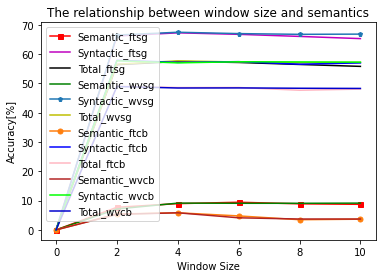

In [ ]:
import matplotlib.pyplot as plt
#等差数列。
x = [0,2,4,6,8,10]
yw1 = [Semantic for Semantic in k1]
yw2 = [Syntactic for Syntactic in k2]
yw3 = [Total for Total in k3]
plt.plot(x,yw1,'rs-',markersize =5,label = 'Semantic_ftsg')
plt.plot(x,yw2,'m-',markersize =5,label = 'Syntactic_ftsg')
plt.plot(x,yw3,'k-',markersize =5,label = 'Total_ftsg')
yw4 = [Semantic for Semantic in k4]
yw5 = [Syntactic for Syntactic in k5]
yw6 = [Total for Total in k6]
plt.plot(x,yw4,'g-',markersize =5,label = 'Semantic_wvsg')
plt.plot(x,yw5,'p-',markersize =5,label = 'Syntactic_wvsg')
plt.plot(x,yw6,'y-',markersize =5,label = 'Total_wvsg')

yw7= [Semantic for Semantic in k7]
yw8 = [Syntactic for Syntactic in k8]
yw9 = [Total for Total in k9]
plt.plot(x,yw7,'o-',markersize =5,label = 'Semantic_ftcb')
plt.plot(x,yw8,'b-',markersize =5,label = 'Syntactic_ftcb')
plt.plot(x,yw9,'#FFB6C1',markersize =5,label = 'Total_ftcb')

yw10 = [Semantic for Semantic in k10]
yw11 = [Syntactic for Syntactic in k11]
yw12 = [Total for Total in k12]
plt.plot(x,yw10,'#B22222',markersize =5,label = 'Semantic_wvcb')
plt.plot(x,yw11,'#00FF00',markersize =5,label = 'Syntactic_wvcb')
plt.plot(x,yw12,'#0000CD',markersize =5,label = 'Total_wvcb')

plt.xlabel('Window Size')
plt.ylabel('Accuracy[%]')
plt.title('The relationship between window size and semantics')
plt.legend()
plt.show()


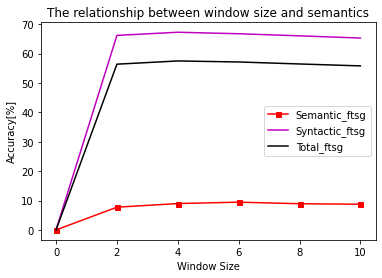

In [ ]:
import matplotlib.pyplot as plt
#等差数列。
x = [0,2,4,6,8,10]
yw1 = [Semantic for Semantic in k1]
yw2 = [Syntactic for Syntactic in k2]
yw3 = [Total for Total in k3]
plt.plot(x,yw1,'rs-',markersize =5,label = 'Semantic_ftsg')
plt.plot(x,yw2,'m-',markersize =5,label = 'Syntactic_ftsg')
plt.plot(x,yw3,'k-',markersize =5,label = 'Total_ftsg')


plt.xlabel('Window Size')
plt.ylabel('Accuracy[%]')
plt.title('The relationship between window size and semantics')
plt.legend()
plt.show()


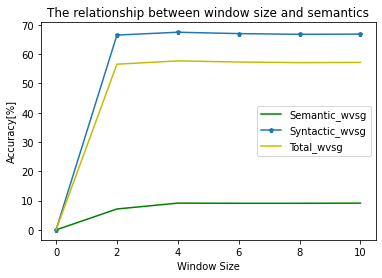

In [ ]:
import matplotlib.pyplot as plt
#等差数列。
x = [0,2,4,6,8,10]

yw4 = [Semantic for Semantic in k4]
yw5 = [Syntactic for Syntactic in k5]
yw6 = [Total for Total in k6]
plt.plot(x,yw4,'g-',markersize =5,label = 'Semantic_wvsg')
plt.plot(x,yw5,'p-',markersize =5,label = 'Syntactic_wvsg')
plt.plot(x,yw6,'y-',markersize =5,label = 'Total_wvsg')

plt.xlabel('Window Size')
plt.ylabel('Accuracy[%]')
plt.title('The relationship between window size and semantics')
plt.legend()
plt.show()


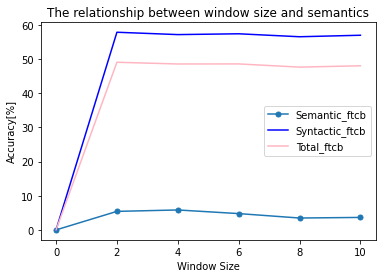

In [ ]:
import matplotlib.pyplot as plt
#等差数列。
x = [0,2,4,6,8,10]

yw7= [Semantic for Semantic in k7]
yw8 = [Syntactic for Syntactic in k8]
yw9 = [Total for Total in k9]
plt.plot(x,yw7,'o-',markersize =5,label = 'Semantic_ftcb')
plt.plot(x,yw8,'b-',markersize =5,label = 'Syntactic_ftcb')
plt.plot(x,yw9,'#FFB6C1',markersize =5,label = 'Total_ftcb')

plt.xlabel('Window Size')
plt.ylabel('Accuracy[%]')
plt.title('The relationship between window size and semantics')
plt.legend()
plt.show()


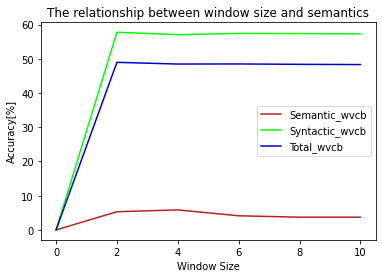

In [ ]:
import matplotlib.pyplot as plt
#等差数列。
x = [0,2,4,6,8,10]

yw10 = [Semantic for Semantic in k10]
yw11 = [Syntactic for Syntactic in k11]
yw12 = [Total for Total in k12]
plt.plot(x,yw10,'#B22222',markersize =5,label = 'Semantic_wvcb')
plt.plot(x,yw11,'#00FF00',markersize =5,label = 'Syntactic_wvcb')
plt.plot(x,yw12,'#0000CD',markersize =5,label = 'Total_wvcb')

plt.xlabel('Window Size')
plt.ylabel('Accuracy[%]')
plt.title('The relationship between window size and semantics')
plt.legend()
plt.show()


In [ ]:
Sem_win_wvsg, Syn_win_wvsg, Tot_win_wvsy = win_change(FastText,1)
Sem_win_ftcb, Syn_win_ftcb, Tot_win_ftcb = win_change(FastText,0)
Sem_win_wvcb, Syn_win_wvcb, Tot_win_wvcb = win_change(FastText,0)
Sem_win_ftsg, Syn_win_ftsg, Tot_win_ftsy = win_change(FastText,1)

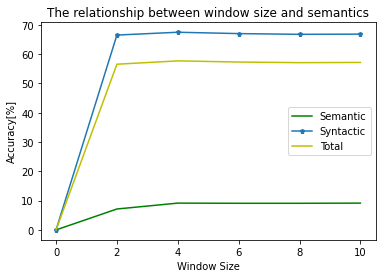

In [ ]:
k4, k5, k6 = appd(Sem_win_wvsg,Syn_win_wvsg,Tot_win_wvsy)
import matplotlib.pyplot as plt
#等差数列。
x = [0,2,4,6,8,10]
yw4 = [Semantic for Semantic in k4]
yw5 = [Syntactic for Syntactic in k5]
yw6 = [Total for Total in k6]
plt.plot(x,yw4,'g-',markersize =5,label = 'Semantic')
plt.plot(x,yw5,'p-',markersize =5,label = 'Syntactic')
plt.plot(x,yw6,'y-',markersize =5,label = 'Total')
plt.xlabel('Window Size')
plt.ylabel('Accuracy[%]')
plt.title('The relationship between window size and semantics')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
#等差数列。
x = [0,2,4,6,8,10]
yw1 = [Semantic for Semantic in k1]
yw2 = [Syntactic for Syntactic in k2]
yw3 = [Total for Total in k3]
plt.plot(x,yw1,'rs-',markersize =5,label = 'Semantic')
plt.plot(x,yw2,'m-',markersize =5,label = 'Syntactic')
plt.plot(x,yw3,'k-',markersize =5,label = 'Total')
plt.xlabel('Window Size')
plt.ylabel('Accuracy[%]')
plt.title('The relationship between window size and semantics')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
#等差数列。
x = [0,2,4,6,8,10]
yw1 = [Semantic for Semantic in k1]
yw2 = [Syntactic for Syntactic in k2]
yw3 = [Total for Total in k3]
plt.plot(x,yw1,'rs-',markersize =5,label = 'Semantic')
plt.plot(x,yw2,'m-',markersize =5,label = 'Syntactic')
plt.plot(x,yw3,'k-',markersize =5,label = 'Total')
plt.xlabel('Window Size')
plt.ylabel('Accuracy[%]')
plt.title('The relationship between window size and semantics')
plt.legend()
plt.show()


In [ ]:
W1,vocab1,W1_norm = open_files(vectors_wv_cbow) #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow
W2,vocab2,W2_norm = open_files(vectors_wv_sg) #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow
W3,vocab3,#  x是epoch y是f1 测试集  command+/
import matplotlib.pyplot as plt
x = [epoch for epoch in range(total_epoch)]
y7 = [f1 for f1 in line_lr[6]]

plt.plot(x,y1,'rs-',markersize =3,label = 'lr=1') # 那个点  红色尺寸点

plt.xlabel('epoch')
plt.ylabel('f1')
plt.title('F1 cases at different learning rates.')
plt.legend() #让标签显示出来
plt.show()
# precision: TP/(TP+FP)
#recallW3_norm = open_files(vectors_ft_sg) #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow
W4,vocab4,W4_norm = open_files(vectors_ft_cbow) #vectors_wv_sg  #vectors_ft_sg #vectors_ft_cbow

In [ ]:
import torch
torch.save({
    'correct_sem': correct_sem, 
    'correct_syn': correct_syn,
    'correct_tot': correct_tot,
    'count_sem': count_sem,
    'count_syn': count_syn,
    'count_tot': count_tot,
    'full_count': full_count   
    }, 'w2v_sg.PATH')   #'w2v_cbow.PATH' ; 'w2v_sg.PATH' ;'ft_sg.PATH' ; 'ft_cbow.PATH'

In [ ]:
import torch
data_w2v_cbow = torch.load('w2v_cbow.PATH')
PP = data_w2v_cbow['correct_sem'] #19
LL = data_w2v_cbow['correct_syn'] #0.6927
P2 = data_w2v_cbow['count_sem']   #tensor([0, 1, 0,  ..., 0, 1, 0])

print(PP)
print(LL)
print(P2)



In [ ]:
import torch
torch.save({
    'correct_sem': correct_sem, 
    'correct_syn': correct_syn,
    'correct_tot': correct_tot,
    'count_sem': count_sem,
    'count_syn': count_syn,
    'count_tot': count_tot,
    'full_count': full_count   
    }, 'w2v_sg.PATH')   #'w2v_cbow.PATH' ; 'w2v_sg.PATH' ;'ft_sg.PATH' ; 'ft_cbow.PATH'

In [ ]:
import torch
data_w2v_sg = torch.load('w2v_sg.PATH')
PP = data_w2v_sg['correct_sem'] #19
LL = data_w2v_sg['correct_syn'] #0.6927
P2 = data_w2v_sg['count_sem']   #tensor([0, 1, 0,  ..., 0, 1, 0])

print(PP)
print(LL)
print(P2)



In [ ]:
import torch
torch.save({
    'correct_sem': correct_sem, 
    'correct_syn': correct_syn,
    'correct_tot': correct_tot,
    'count_sem': count_sem,
    'count_syn': count_syn,
    'count_tot': count_tot,
    'full_count': full_count   
    }, 'ft_sg.PATH')   #'w2v_cbow.PATH' ; 'w2v_sg.PATH' ;'ft_sg.PATH' ; 'ft_cbow.PATH'

In [ ]:
import torch
data_ft_sg = torch.load('ft_sg.PATH')
PP = data_ft_sg['correct_sem'] #19
LL = data_ft_sg['correct_syn'] #0.6927
P2 = data_ft_sg['count_sem']   #tensor([0, 1, 0,  ..., 0, 1, 0])

print(PP)
print(LL)
print(P2)



In [ ]:
import torch
torch.save({
    'correct_sem': correct_sem, 
    'correct_syn': correct_syn,
    'correct_tot': correct_tot,
    'count_sem': count_sem,
    'count_syn': count_syn,
    'count_tot': count_tot,
    'full_count': full_count   
    }, 'ft_cbow.PATH')   #'w2v_cbow.PATH' ; 'w2v_sg.PATH' ;'ft_sg.PATH' ; 'ft_cbow.PATH'

In [ ]:
import torch
data_ft_cbow = torch.load('ft_cbow.PATH')
PP = data_ft_cbow['correct_sem'] #19
LL = data_ft_cbow['correct_syn'] #0.6927
P2 = data_ft_cbow['count_sem']   #tensor([0, 1, 0,  ..., 0, 1, 0])

print(PP)
print(LL)
print(P2)

